In [51]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from pathlib import Path

In [ ]:
import kagglehub

# Download latest version
BASE_DIR = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", BASE_DIR)

# 1. Data Loading

In [54]:
# Dynamically find the train/test subfolders
notebook_dir = Path().resolve()
project_root = notebook_dir.parent             
data_root    = project_root / "data"           

train_folder = next(p for p in data_root.iterdir() if p.is_dir() and p.name.lower().startswith("train"))
test_folder  = next(p for p in data_root.iterdir() if p.is_dir() and p.name.lower().startswith("test"))

TRAIN_DIR = str(train_folder)
TEST_DIR  = str(test_folder)

print(f"TRAIN_DIR = {TRAIN_DIR}")
print(f"TEST_DIR  = {TEST_DIR}")

TRAIN_DIR = /Users/simonvellin/Documents/BSE/TERM 3/HIGH DIMENSIONAL ANALYSIS/HOMEWORKS/data/Training
TEST_DIR  = /Users/simonvellin/Documents/BSE/TERM 3/HIGH DIMENSIONAL ANALYSIS/HOMEWORKS/data/Testing


In [48]:
BASE_DIR    = '/Users/simonvellin/Documents/BSE/TERM 3/HIGH DIMENSIONAL ANALYSIS/HOMEWORKS/data'        # in case locally downloaded
TRAIN_DIR   = os.path.join(BASE_DIR, 'Training')
TEST_DIR    = os.path.join(BASE_DIR, 'Testing')

In [ ]:
classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"Detected classes: {classes}")

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# 2. EDA

Training counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing counts:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


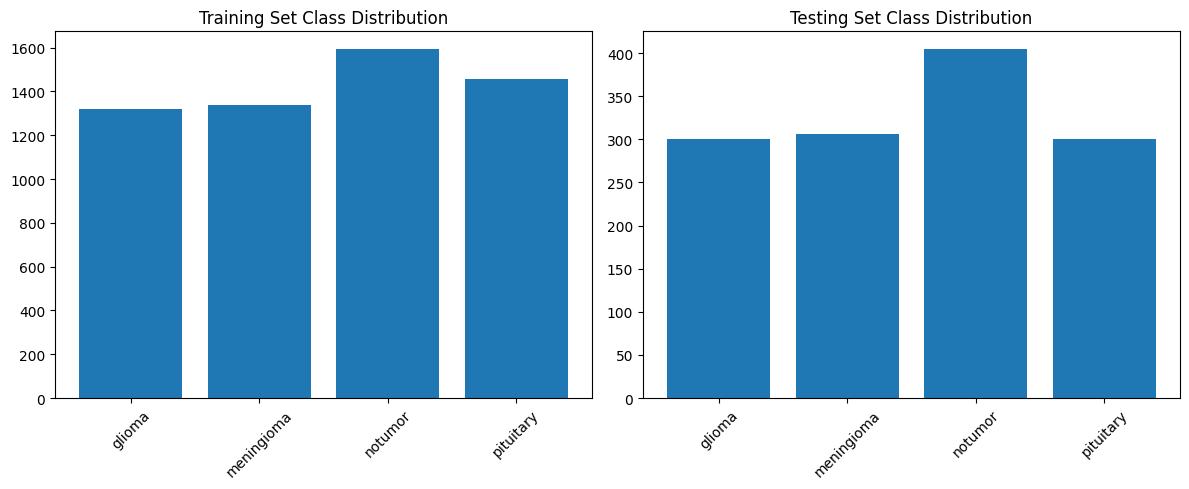

In [41]:
# Count images per class
def count_images(folder):
    return {cls: len(os.listdir(os.path.join(folder, cls))) for cls in classes}

train_counts = count_images(TRAIN_DIR)
test_counts  = count_images(TEST_DIR)

print("Training counts:", train_counts)
print("Testing counts: ", test_counts)

# Plot class imbalance
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title('Testing Set Class Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

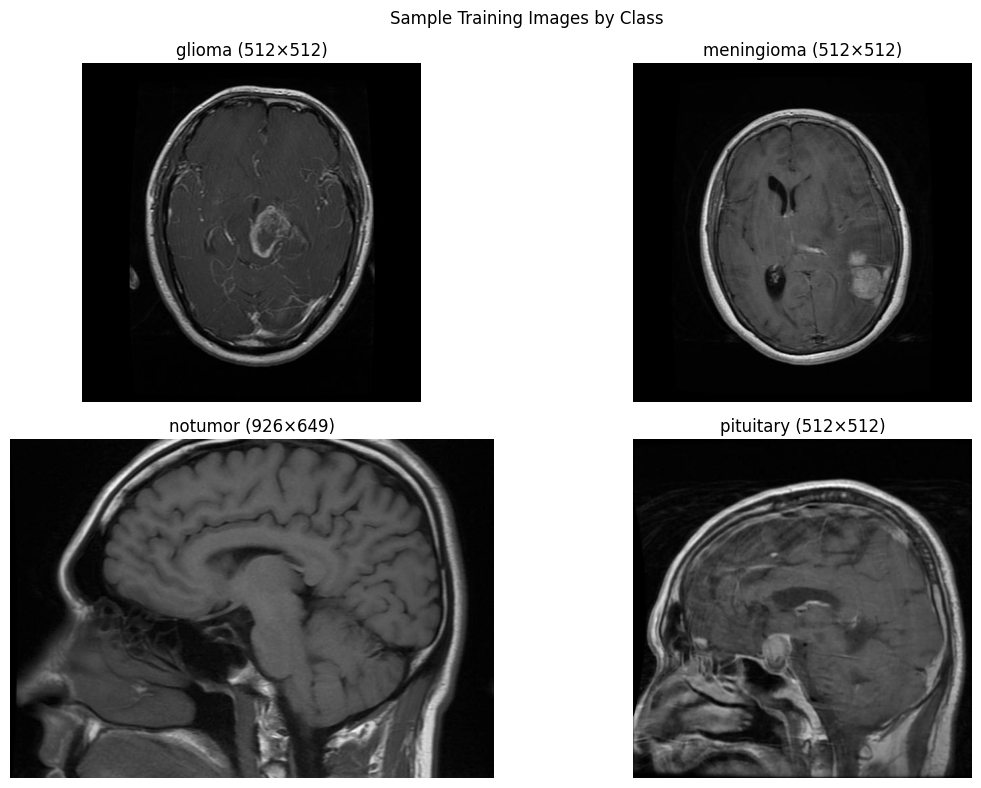

In [42]:
# Display one random sample per class (from training set)
plt.figure(figsize=(12,8))
for i, cls in enumerate(classes):
    ax = plt.subplot(2, 2, i+1)
    img_name = random.choice(os.listdir(os.path.join(TRAIN_DIR, cls)))
    img_path = os.path.join(TRAIN_DIR, cls, img_name)
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{cls} ({img.size[0]}×{img.size[1]})")
    ax.axis('off')

plt.suptitle('Sample Training Images by Class')
plt.tight_layout()
plt.show()

# 3. Data Wrangling

## a) Resizing Resolution

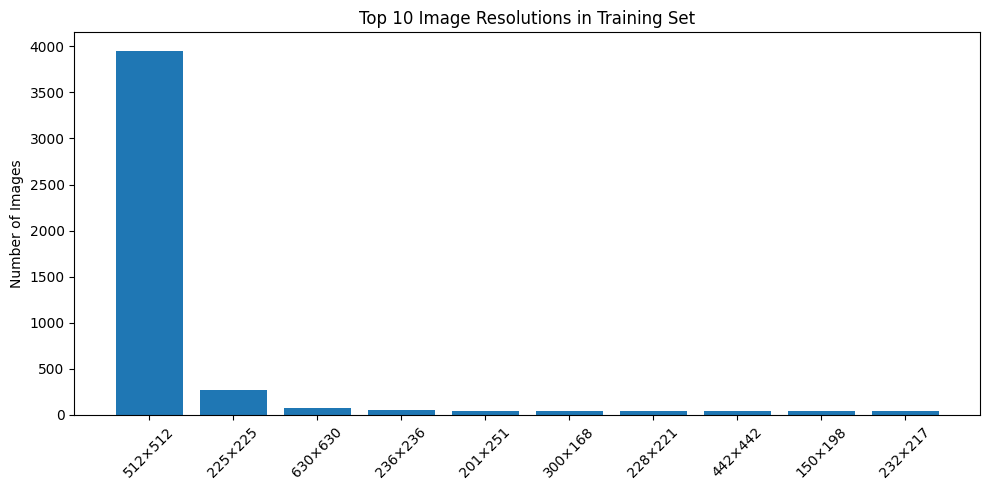

In [45]:
# Gather and count all training-image resolutions
size_counts = Counter()
for cls in classes:
    cls_dir = os.path.join(TRAIN_DIR, cls)
    for fname in os.listdir(cls_dir):
        w, h = Image.open(os.path.join(cls_dir, fname)).size
        size_counts[(w, h)] += 1

# Plot the top-10 most common resolutions
common = size_counts.most_common(10)
labels  = [f"{w}×{h}" for (w, h), _ in common]
counts  = [cnt for _, cnt in common]

plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.title("Top 10 Image Resolutions in Training Set")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

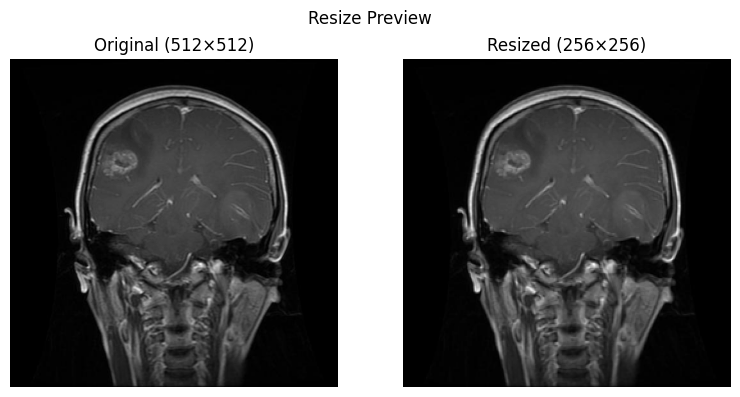

In [46]:
# Preview resizing to a fixed target size
TARGET_SIZE = (256, 256)
sample_cls   = classes[0]
sample_file  = random.choice(os.listdir(os.path.join(TRAIN_DIR, sample_cls)))
orig_img     = Image.open(os.path.join(TRAIN_DIR, sample_cls, sample_file))
resized_img  = orig_img.resize(TARGET_SIZE)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_img, cmap='gray')
plt.title(f"Original ({orig_img.size[0]}×{orig_img.size[1]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(resized_img, cmap='gray')
plt.title(f"Resized ({TARGET_SIZE[0]}×{TARGET_SIZE[1]})")
plt.axis('off')

plt.suptitle("Resize Preview")
plt.tight_layout()
plt.show()

## b) Resizing Loop

`Why 224×224?`

Most widely adopted backbones (ResNet, VGG, EfficientNet, MobileNet, etc.) are pre‐trained on ImageNet images resized to **224×224**. By matching this input size:

1. **Leverage Transfer Learning**  
   - Import pre‐trained weights without architectural changes.  
   - Benefit from general “edge” and “texture” features learned on millions of images.

2. **Ensure Architectural Consistency**  
   - Convolutional blocks, pooling layers, and fully‐connected heads are tuned for 224×224.  
   - Preserves expected feature map dimensions, avoiding manual re‐engineering of strides or global pooling.

3. **Maintain Efficient Computation**  
   - Balances detail retention (sufficient resolution for tumor boundaries) with GPU memory limits.  
   - Smaller than full MRI resolution, but large enough to capture critical anatomy.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# 2.1 Parameters
BATCH_SIZE = 32
IMG_SIZE    = (224, 224)    # down‐sample or up‐sample everything here
SEED        = 42

# 2.2 Create train/validation datasets from Training folder
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 2.3 Create test dataset (no split, no shuffle)
test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 2.4 Peek at class names and cardinality
print("Classes:", train_ds.class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val   batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test  batches:", tf.data.experimental.cardinality(test_ds).numpy())

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Train batches: 143
Val   batches: 36
Test  batches: 41


In [58]:
# 2.5 Normalization & Augmentation pipelines
normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def preprocess(image, label, augment=False):
    image = normalization_layer(image)
    if augment:
        image = data_augmentation(image)
    return image, label

# 2.6 Apply preprocessing and prefetch for performance
train_ds = train_ds.map(lambda x, y: preprocess(x, y, augment=True)) \
                   .prefetch(tf.data.AUTOTUNE)

val_ds   = val_ds.map(lambda x, y: preprocess(x, y, augment=False)) \
                 .prefetch(tf.data.AUTOTUNE)

test_ds  = test_ds.map(lambda x, y: preprocess(x, y, augment=False)) \
                 .prefetch(tf.data.AUTOTUNE)

print("Samples from train_ds:")
for images, labels in train_ds.take(1):
    print(" image batch shape:", images.shape)
    print(" label batch shape:", labels.shape)

Samples from train_ds:
 image batch shape: (32, 224, 224, 3)
 label batch shape: (32, 4)


2025-06-16 23:27:22.003925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
